In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [2]:
# Đọc tệp shapefile sử dụng GeoPandas
gdf = gpd.read_file('../Data/gadm41_VNM_2.shp')

# Filter for TP.HCM
gdf_hcm = gdf[gdf['NAME_1'] == 'Há»\x93 ChÃ\xad Minh']

# Rename column "VARNAME2" to"District" 
gdf_hcm = gdf_hcm.rename(columns={'VARNAME_2': 'District'})

# Reformatting name of district
replace_dict = {'Binh Chanh':'binh-chanh', 'Binh Tan' : 'binh-tan','Binh Thanh':'binh-thanh', 'Can Gio':'can-gio', 
 'Cu Chi':'cu-chi', 'Go Vap':'go-vap', 'Hoc Mon':'hoc-mon', 'Nha Be':'nha-be', 'Phu Nhuan':'phu-nhuan', 
 'District 1':'quan-1', 'District 10':'quan-10', 'District 11':'quan-11', 'District 12':'quan-12', 'District 2':'quan-2', 
 'District 3':'quan-3', 'District 4':'quan-4', 'District 5':'quan-5', 'District 6':'quan-6', 'District 7':'quan-7', 
 'District 8':'quan-8', 'District 9':'quan-9', 'Tan Binh':'tan-binh',  'Tan Phu':'tan-phu', 'Thu Duc':'thu-duc'}
gdf_hcm['District'] = gdf_hcm['District'].replace(replace_dict)

In [3]:
# Read cleaned file with district
df = pd.read_csv('../Data/data_with_district.csv')

# Keep columns 'District','Price_per_sqm','Month' in dataframe
df = df[['District','Price_per_sqm','Month']]

# Merge geodataframe and dataframe to a new file csv contain data and geodata
df = gdf_hcm.merge(df, on='District')
df.to_csv('../Data/data_with_gadm.csv', index = False)

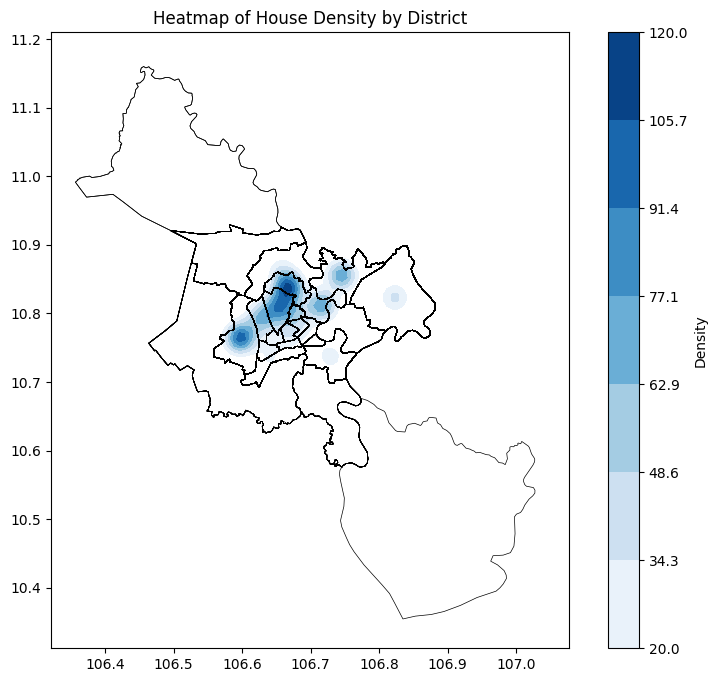

In [4]:
data = pd.read_csv('../Data/data_with_gadm.csv')

# Chuyển đổi cột 'geometry' sang GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry=gpd.GeoSeries.from_wkt(data['geometry']))

# Trích xuất tọa độ trung tâm của mỗi quận
gdf['centroid'] = gdf.geometry.centroid.apply(lambda point: (point.x, point.y))

# Trích xuất tọa độ
coordinates = np.array(gdf['centroid'].tolist())

# Tạo KDE
kde = KernelDensity(bandwidth=0.015, metric='euclidean')
kde.fit(coordinates)

# Đánh giá KDE trên một lưới điểm
xmin, ymin, xmax, ymax = gdf.total_bounds
xgrid = np.linspace(xmin + 0.05, xmax + 0.05, 100)
ygrid = np.linspace(ymin + 0.05, ymax + 0.05, 100)
X, Y = np.meshgrid(xgrid, ygrid)
xy_sample = np.vstack([X.ravel(), Y.ravel()]).T
Z = kde.score_samples(xy_sample)
Z = np.exp(Z).reshape(X.shape)

# Vẽ heatmap
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels = np.linspace(20, 120, 8), cmap='Blues')
plt.colorbar(label = 'Density')
plt.title('Heatmap of House Density by District')

# Vẽ bản đồ quận
gdf.boundary.plot(ax=plt.gca(), linewidth = 0.5, edgecolor='black')
plt.show()

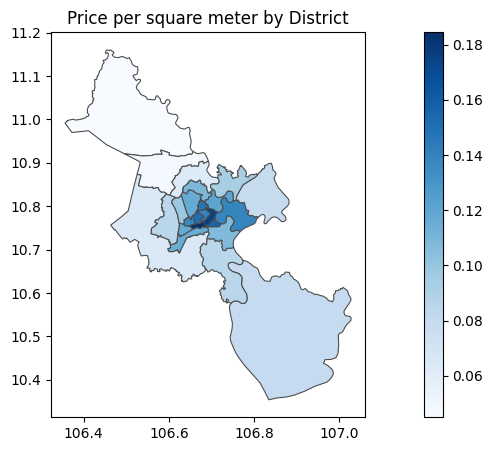

In [5]:
# Nhóm dữ liệu theo cột 'District' và tính giá trị trung bình của 'Price_per_sqm' cho mỗi quận
price_per_sqm_mean_by_district = df.groupby('District')['Price_per_sqm'].mean().reset_index()

# Đổi tên cột để rõ ràng hơn
price_per_sqm_mean_by_district.rename(columns={'Price_per_sqm': 'price_per_sqm_mean'}, inplace=True)

# Hợp nhất dữ liệu số lượng nhà bán với dữ liệu bản đồ hành chính
gdf = gdf_hcm.merge(price_per_sqm_mean_by_district, on='District')

# Vẽ bản đồ nhiệt
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

gdf.plot(column='price_per_sqm_mean', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.3', legend=True)

plt.title('Price per square meter by District')
plt.show()